#  Summary of CDS Return Replication

In [22]:
# Imports and path setup
import sys
from pathlib import Path
import io
import re
import datetime

import numpy as np
import pandas as pd
import polars as pl
import requests
from matplotlib import pyplot as plt
import seaborn as sns

# Plotting style
sns.set()

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Load project settings
from settings import config
DATA_DIR = Path(config("DATA_DIR")) / "wrds_markit"
HE_DATA_DIR = Path(config("DATA_DIR"))

# Load project modules
from he_kelly_manela import pull_he_kelly_manela
from wrds_markit import pull_markit_cds, pull_fed_yield_curve, calc_cds_returns


In [14]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

## 1. Introduction

This notebook replicates monthly CDS portfolio returns as constructed in He, Kelly, and Manela (2017) and Palhares (2013)'s paper *"Cash-Flow Maturity and Risk Premia in CDS Markets."*

> "For CDS, we construct 20 portfolios sorted by spreads using individual name 5-year contracts... Our definition of CDS returns follows Palhares (2013)."

While He, Kelly, and Manela (2017) construct CDS portfolios using data up to 2012, in this notebook we extend the sample period through 2024 for demonstration purposes.  



In [ ]:
# TODO: MAKE THIS AUTOMATION The underlying Python modules used for data retrieval and processing are designed to be modular and automated, allowing replication to dynamically incorporate the latest available data with minimal modification.

### Target Replication: Quarterly CDS Return Structure

The CDS return series consists of 20 portfolios, formed by sorting 5-year single-name CDS contracts into 4 quintiles based on credit spreads. Each month, returns are computed for portfolios within each quintile, producing 20 total portfolios.


In [23]:
he_kelly = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=HE_DATA_DIR )

In [24]:
col_lst = ["yyyymm"]
for i in range(1,10):
    col_lst.append(f"CDS_0{i}")
for i in range(10,21):
    col_lst.append(f"CDS_{i}")

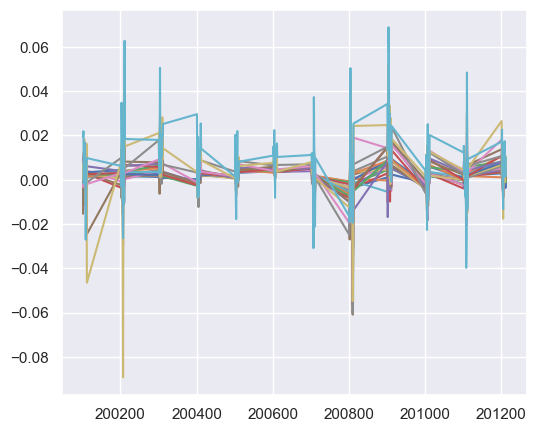

In [25]:
he_kelly_df = he_kelly[col_lst].dropna(axis=0).set_index("yyyymm")

plt.plot(he_kelly_df)
    

## 2. Data Retrieval

We retrieve the datasets required to replicate the quarterly CDS returns. Retrieval scripts are modularized by source.

### 2.1 CDS Data from Markit

Following He et al. and Palhares, we use Markit as the source for CDS-related information. Specifically, we filter data by the following conditions:

- `currency = 'USD'`: USD-denominated CDS contracts only  
- `docclause LIKE 'XR%%'`: Only XR (no restructuring) contracts  
- `CompositeDepth5Y >= 3`: Minimum 3 dealer submissions for 5Y quotes  
- `tenor IN ('1Y', '3Y', '5Y', '7Y', '10Y')`: Focus on standard maturities


In [ ]:
cds_df = pull_markit_cds.load_cds_data(data_dir=DATA_DIR)

In [ ]:
cds_df.columns

### 2.2 Federal Reserve Zero-Coupon Yields
In this step, we download and process the [U.S. Treasury zero-coupon yield curve data]((https://www.federalreserve.gov/econres/feds/the-us-treasury-yield-curve-1961-to-the-present.htm)) published by the Federal Reserve Board. This dataset is based on the Gürkaynak, Sack, and Wright (2007) methodology, which fits a smooth yield curve to observed Treasury yields.   
We retrieve zero-coupon yield data directly from the Federal Reserve, labeled SVENY01 to SVENY30, representing 1-year to 30-year maturities.


In [27]:
fed_df = pull_fed_yield_curve.load_fed_yield_curve(data_dir=DATA_DIR)

In [28]:
fed_df.columns

Index(['SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05', 'SVENY06',
       'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11', 'SVENY12',
       'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17', 'SVENY18',
       'SVENY19', 'SVENY20', 'SVENY21', 'SVENY22', 'SVENY23', 'SVENY24',
       'SVENY25', 'SVENY26', 'SVENY27', 'SVENY28', 'SVENY29', 'SVENY30'],
      dtype='object')

### 2.3 Treasury Yield Data

To calculate risk-free rates at shorter maturities, we also retrieve 3-month and 6-month Treasury yields (DGS3MO and DGS6MO) from FRED.

In [29]:
swap_rates_df = pull_fed_yield_curve.load_fed_yield_curve(data_dir=DATA_DIR)

In [30]:
swap_rates_df.head(5)

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,SVENY11,SVENY12,...,SVENY19,SVENY20,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1961-06-14,2.982,3.377,3.553,3.644,3.699,3.735,3.761,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-15,2.994,3.414,3.598,3.693,3.750,3.788,3.815,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-16,3.001,3.414,3.599,3.695,3.753,3.792,3.819,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-19,2.995,3.439,3.625,3.720,3.777,3.815,3.842,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-20,2.983,3.410,3.599,3.695,3.753,3.792,3.820,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Replication

We follow the return formula used in *He-Kelly-Manela (2017)*, referencing Palhares:

$$
\text{CDS}^{Ret}_t = \frac{\text{CDS}_{t-1}}{250} + \Delta \text{CDS}_t \cdot \text{RD}_{t-1}
$$

Where:

- $\frac{\text{CDS}_{t-1}}{250}$: **Carry return**, daily accrual from previous day’s spread (annualized over 250 days)  
- $\Delta \text{CDS}_t$: Daily change in spread  
- $\text{RD}_{t-1}$: **Risky duration**, proxy for PV of future spread payments

$$
\text{RD}_t = \frac{1}{4} \sum_{j=1}^{4M} e^{-j\lambda/4} \cdot e^{-jr_t^{(j/4)}/4}
$$

Where:

- $M$: CDS maturity (e.g., 5)  
- $r_t^{(j/4)}$: Quarterly risk-free rate  
- $\lambda$: Default intensity, computed as:

$$
\lambda = 4 \cdot \log \left(1 + \frac{\text{CDS}}{4L} \right), \quad L = 0.6
$$


### 3.1. Risk-Free Rate Calculation

We calculate the quarterly risk-free rates $r_t^{(j/4)}$ via interpolation, since the raw data is only available annually (plus 0.25Y and 0.5Y points). Cubic interpolation fills in missing quarterly maturities.

Even though returns are monthly, we retain quarterly rates under the assumption that CDS spreads are paid quarterly.

### 3.2. Monthly Return Computation

We compute monthly CDS returns by applying the above formula for each individual name and maturity. Spread data is first aligned and cleaned at the monthly frequency.

### 3.3. Portfolio Construction

We focus on U.S.-based 5Y CDS contracts and process spreads monthly. For each firm in each month, we keep only the **first observed 5Y par spread**, ensuring consistency in time series construction.

To sort firms into credit quality groups, we compute quintiles based on the cross-sectional distribution of 5Y spreads for each month. These breakpoints define five credit buckets (quantiles 1–5), from safest to riskiest.

We then assign each firm a quantile label based on their spread ranking. This quantile label is merged back into the full dataset, including other tenors (3Y, 7Y, 10Y), allowing us to analyze spread dynamics across maturities while controlling for credit quality.

Finally, we compute the **average par spread** for each combination of:

* Tenor ∈ {3Y, 5Y, 7Y, 10Y}
* Credit Quantile ∈ {1, 2, 3, 4, 5}

This results in 20 tenor–quantile portfolios, each with a monthly spread time series.



In [ ]:
final_result = pd.read_parquet(DATA_DIR / "markit_cds_returns.parquet")
final_result.head(5)
# TODO: any graphs needed?